## Load modules and read in data

First, we will import all the modules needed for this analysis.

In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
from glob import glob
import os
import random

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [3]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [12]:
# Define data directory
infotheory_measure_dir = "infotheory_measures/"

# Load SPI groupings
infotheory_measure_info = pd.read_csv("data/infotheory_measure_info.csv")

# Load results for HCP participant 298051
subject_ID = "298051"
HCP_rsfMRI_info_theory_res = pd.read_csv(f"data/HCP_{subject_ID}_rsfMRI_infotheory_measures.csv").merge(infotheory_measure_info, on="Measure", how='left')

In [13]:
HCP_rsfMRI_info_theory_res.head()

,Measure,region_from,region_to,Measure_Type,value,Base_Region,Sample_ID,Measure_name,Group,Group_number
0,entropy_kozachenko,lateraloccipital,lateraloccipital,Univariate,1.398528,lateraloccipital,298051,Entropy,Univariate order-independent,1
1,AIS_kraskov,lateraloccipital,lateraloccipital,Univariate,0.578941,lateraloccipital,298051,Active information storage,Univariate order-dependent,4
2,entropy_kozachenko,parstriangularis,parstriangularis,Univariate,1.441374,parstriangularis,298051,Entropy,Univariate order-independent,1
3,AIS_kraskov,parstriangularis,parstriangularis,Univariate,0.268617,parstriangularis,298051,Active information storage,Univariate order-dependent,4
4,je_kozachenko,lateraloccipital,parstriangularis,Bivariate,2.838691,NaN,298051,Joint entropy,"Bivariate order-independent, undirected",2


`summarise()` has grouped output by 'region_to', 'Measure_name'. You can
override using the `.groups` argument.
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning message:
In left_join(., as_tibble(dk)) :
  Detected an

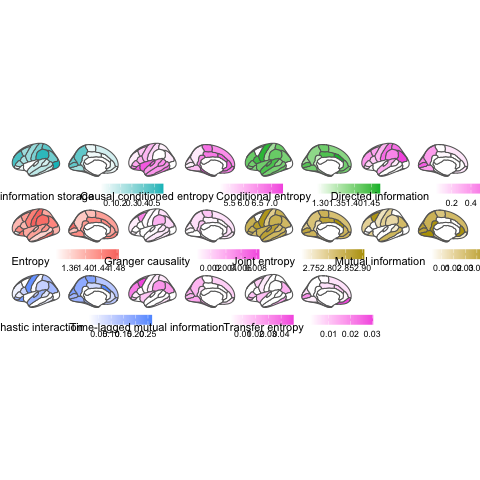

In [14]:
%%R -i HCP_rsfMRI_info_theory_res -o mean_measure_value_by_region

# Generate default color palette
gg_color_hue <- function(n) {
      hues = seq(15, 375, length = n + 1)
      hcl(h = hues, l = 65, c = 100)[1:n]
      }
group_colors <- gg_color_hue(6)

# Let's plot this in the brain
mean_measure_value_by_region <- HCP_rsfMRI_info_theory_res %>%
  group_by(region_to, Measure_name, Group_number) %>%
  summarise(mean_value = mean(value, na.rm=T)) %>%
  ungroup() %>%
  mutate(label = glue("lh_{region_to}"),
         mean_value = ifelse(mean_value<0, NA_real_, mean_value))
  
mean_measure_value_by_region_dk <- mean_measure_value_by_region %>%
  left_join(., as_tibble(dk))

plot_list <- list()
for (measure in unique(mean_measure_value_by_region_dk$Measure_name)) {
      this_measure_data <- subset(mean_measure_value_by_region_dk, Measure_name==measure)
      measure_group_color <- group_colors[this_measure_data$Group_number][1]
      p <- mean_measure_value_by_region_dk %>%
            filter(Measure_name==measure) %>%
            ggseg(atlas = dk, 
                  # mapping = aes(fill = mean_value_norm),
                  mapping=aes(fill=mean_value),
                  position = "stacked", colour = "gray40", hemisphere="left") +
            theme_void() +
            labs(fill = measure) +
            theme(plot.title = element_blank(),
                  legend.key.width = unit(0.45, "cm"),
                  legend.key.height = unit(0.35, "cm"),
                  legend.position = "bottom") +
            scale_fill_gradient(low="white", high=measure_group_color, na.value="white")
      plot_list[[measure]] <- p
}

wrap_plots(plot_list)
# ggsave("../figures/figure_drafting/HCP_rsfMRI_info_theory_measures_in_brain.svg", width=10, height=5, units="in", dpi=300)